# Drawingboard / notes / todo:
### What we're going: How we cluster into topics that make sense, then we check with the job title or other content to confirm that
- Embeddings are the decomposition of each word or documents as its own vector to a factorization to a much lower dimension space - k number of columns/rows.  Thus, if we have 15 topics, then the W and H matrices will have document and word embedding in 15 dimension space.
- We create orthognal vectors for the embeddings, which are vectors that have a dot product of 0 with each other, which is also thought of as everything cancelling out.
- Or, we solve with alternating least squares?

Questions from ben
- What are the tuning part?
  Maybe I can come up with either an flask interface, or a notebook?
  Or, just indicate the hyper parameters
  Dont spend too much time on impl of tags specifics
  Get my story better

Hyperparam tuning - possible with unsupervised learning?
Statistical modeling?  Other plots?

data prep
x stem the data before dropping in TFIDF
- identify/explciitly indicate synonyms?
- user application history (might just be rules though)
- tfidf ngrams
- add to vectorizer weights
- - view dataframe of vectoizer with words on cols and docs on rows

Generate topics
x from all documents
- prefiltered by tag names
- using only job titles
- manually weighted words or parts of a document
- part of speech weighting

GridSearch / Pipeline

Compare listings
- list of docs most similar to any given other listing
Compare to resume
- list of docs most similar to a resume
- use multiple section elements of the resume as paragraphs (like comparing multiple document pairs and such)

Plots/Prints
x top tags per topic, and their proportion
- top terms per topic (in function outside of tm.fit)
- term/doc representation - df or output to csv of docs on rows and words on cols with values as the tfidf score
- heatmap, 
- - NMF heatmap python
- 2d principal components graphic
- k-means clustering on the vectors, the plot in 2d with PCA?

Use w2v to test coherence
Classify one document using the generated topics

Make recommendation
- Using other jobs with same topic number 
- ..and same tag?
- ..and highes prob?
- Use gensim for highest matching job document for the current query job, then highest matching job using the user's vectorized resume.  Then assign a score to both, then sort by the average of the 2 scores, and pick the top one.
- - I believe I can use the same trained vectorizer/vocabulary to train the NMF with resume data, then do a highest similarity match using the word2vec similarity comapre.  But that wont have the same labeled sentences.  Maybe use word2vec and not doc2vec?

Pipline class (https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn)
- text_clf = Pipeline([('vect', stem_vectorizer), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='linear', C=1)) ])

Todo:
- Instead of getting signal, maybe I can identify relationships between words and topics and other sleuthing.
- nimfa module
- remove all adjectives?
- decorator for time

## 1 - Hyperparam tuning


## 2 - tags
Create multiple cluster groups
- main for all jobs
- 5 clusters for each tag group

For query doc
- subset group of jobs with those tags
- - if less than say 10 jobs with that tag(s), run on all tags

Or

for each of the 16 clusters,
- run a doc2vec on the sub cluster and get the most similar to the job desc
- cross against user resume?

In [1]:
# import time
# import applicants
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.feature_extraction import text
# from sklearn.decomposition import NMF, LatentDirichletAllocation
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from nltk.stem.porter import PorterStemmer
# from nltk.stem import WordNetLemmatizer
# import gensim
# from numpy.random import rand
# from itertools import combinations
# import time
# import operator
# import re
# import os
import topic_model, dataio, nlp_utils, jobs

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#df_users = applicants.get_applicant_data()

# Get the data and dataframe

In [2]:
df_jobs = jobs.get_job_posting_data()
#df_jobs = df_jobs[:1000].reset_index()  # Use a subset for faster dev iteration
print df_jobs.shape

docs = df_jobs.description
titles = df_jobs.title

Getting job posting data...
- Time: 0.605592012405

(24015, 5)


In [6]:
c = titles.value_counts()
c[c < 19]

Experienced Barista                                                            9
Baristas                                                                       9
Apprentice Chocolate Maker                                                     9
Senior Accountant                                                              9
Experienced Server                                                             9
Operations Associate                                                           9
Server/Bartender                                                               9
Director of Programs                                                           9
Barista/Bartender                                                              9
Spa Attendant                                                                  9
Part Time Sales Associate                                                      9
Barback                                                                        9
Admin Assistant             

# Perform the topic modeling <BR>- append the topic data to the docs in the dataframe

In [6]:
# Params to build the vocab and topics
min_df = 10
max_df = .5
k_topics = 18
max_vocab_size = 10000
ngram_range=(1,1)

tm = topic_model.TopicModeller(model_type='NMF', vectorizer_type='localwise',
                               max_vocab_size=max_vocab_size, 
                               min_df=min_df, 
                               max_df=max_df, 
                               ngram_range=ngram_range, 
                               k_topics=k_topics)
tm.vectorize(docs)
tm.document_term_mat = nlp_utils.boost_doc_title_terms_tfidf(titles, tm.vectorizer, tm.document_term_mat, scale=1)
tm.fit(docs)

Number of documents to process: 24015

Extracting Vectorizer features...
- Time: 26.527s.

Boosting title terms in document term matrix...
- Time: 20.255s.

Fitting nmf model with 24015 documents.  Vectorizer: 
LocalwiseVectorizer(inflection_form='lemmer', max_df=0.5, max_features=10000,
          min_df=10, ngram_range=(1, 1))
- Time: 22.865s.

Reconstruction mse: 0.000241
Topic 0: assistant, administrative, office, executive, receptionist, salon, project, task, general, phone, personal, assist, operation, legal, accounting

Topic 1: cook, line, prep, restaurant, grill, cooking, pizza, breakfast, menu, station, fast, lunch, brunch, knife, cafe

Topic 2: sale, retail, representative, store, customer, product, account, inside, business, lead, market, solar, commission, brand, boutique

Topic 3: manager, office, operation, store, general, case, project, restaurant, account, business, management, kitchen, development, resource, community

Topic 4: teacher, preschool, school, child, lead, 

In [7]:
tokens = nlp_utils.get_tagged_docs(docs, 'asdf')

Tokenizing docs...
- Time: 23.691s.



In [8]:
top_topics, top_topic_weights = tm.get_top_topics_and_topic_probs()

df_jobs['top_topic'] = top_topics
df_jobs['top_topic_weight'] = top_topic_weights

topic_model.py:223: RuntimeWarning: invalid value encountered in divide
  probs = (topic_weights / topic_weights.sum())


In [9]:
# df_jobs

# Do some exploration of the topic modeling data distribution

Total records: 24015
= 1: 601 (0.0250260254008)
> .75: 7326 (0.305059337914)
> .50 < .75: 6506 (0.270914012076)
> .25 < .50: 7614 (0.317051842598)
< .25: 2332 (0.097105975432)


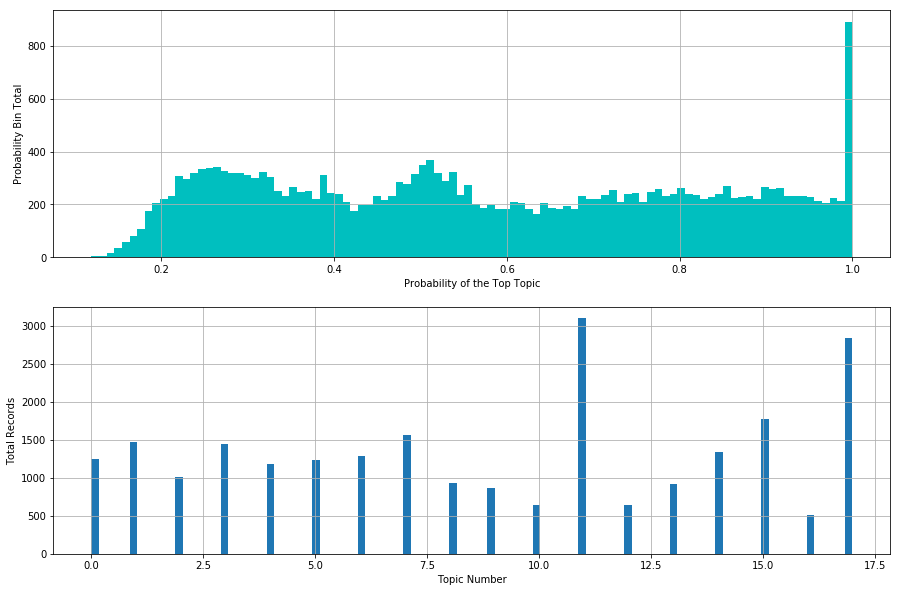

In [10]:
# Plot/Print topic probablity distributions and counts for the topic clusters
total = df_jobs.shape[0]
print 'Total records: %s' % total
one = df_jobs.top_topic_weight[df_jobs.top_topic_weight == 1].shape[0]
print '= 1: %s (%s)' % (one, (float(one)/ total))
q4 = df_jobs.top_topic_weight[df_jobs.top_topic_weight > .75].shape[0]
print '> .75: %s (%s)' % (q4, (float(q4)/ total))
q3 = df_jobs.top_topic_weight[(df_jobs.top_topic_weight > .5) & (df_jobs.top_topic_weight < .75)].shape[0]
print '> .50 < .75: %s (%s)' % ((q3, float(q3)/ total))
q2 = df_jobs.top_topic_weight[(df_jobs.top_topic_weight > .25) & (df_jobs.top_topic_weight < .5)].shape[0]
print '> .25 < .50: %s (%s)' % ((q2, float(q2)/ total))
q1 = df_jobs.top_topic_weight[df_jobs.top_topic_weight < .25].shape[0]
print '< .25: %s (%s)' % ((q1, float(q1)/ total))

# print df_jobs.top_topic_weight[df_jobs.top_topic_weight == 1]

plt.figure(figsize=(15,5));
fig, axarr = plt.subplots(2, 1, figsize=(15,10));
axarr[0].set_xlabel('Probability of the Top Topic');
axarr[0].set_ylabel('Probability Bin Total');
df_jobs.top_topic_weight.hist(ax=axarr[0], bins=100, color='c');
axarr[1].set_xlabel('Topic Number');
axarr[1].set_ylabel('Total Records');
df_jobs.top_topic.hist(ax=axarr[1], bins=100);

In [11]:
term_ranks = tm.rank_terms()

top_n = 20
print "Top %s terms across all %s terms (ranked by the term's vector tfidf sum):" % (top_n, len(tm.vectorizer.vocabulary_))
for i, pair in enumerate( term_ranks[0:top_n] ):
    print( "  %02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

Top 20 terms across all 9860 terms (ranked by the term's vector tfidf sum):
  01. manager (1824.89)
  02. cook (1812.34)
  03. assistant (1680.61)
  04. sale (1419.20)
  05. service (1204.58)
  06. line (1121.30)
  07. teacher (1094.28)
  08. server (1055.30)
  09. associate (1012.88)
  10. program (992.04)
  11. customer (965.72)
  12. coordinator (716.15)
  13. food (682.18)
  14. office (680.56)
  15. school (674.82)
  16. restaurant (620.11)
  17. dishwasher (618.08)
  18. marketing (586.72)
  19. kitchen (572.00)
  20. member (560.01)


In [12]:
doc_with_weights_one = df_jobs[df_jobs.top_topic_weight == 1.0]
doc_with_weights_one.head()

,id,business_id,title,description,tag_names,top_topic,top_topic_weight
21,7324,1932,Line Cook,Bissab baobab in SF is looking for someone to ...,Food & Drink,1,1.0
83,2927,2322,Marketing Assembly Gig,I have a bunch of marketing materials for some...,"Other,Startups & Technology,Food & Drink",15,1.0
84,4438,2322,Marketing,"Doing marketing work in Berkeley, whether at C...","Other,Startups & Technology,Food & Drink",15,1.0
88,8493,2342,Indoor Cycling Instructor,> CRUfit is seeking an outgoing indoor cycling...,Health & Fitness,14,1.0
134,19972,2590,Indoor-Cycling Instructor (Audition),"RiDE Oakland, Oakland's premier dedicated indo...",Health & Fitness,14,1.0


# Document record exploration

In [13]:
doc_idx = 12
doc_lw_id = df_jobs.iloc[doc_idx].id
print 'doc_idx: %s \nlw record number: %s' % (doc_idx, doc_lw_id)

print '- Top terms:'
tfidf_scores = tm.get_doc_terms_and_scores(doc_idx)
for key, value in sorted(tfidf_scores.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    print "{:<10}: {:<10}".format(key, value)
    
dfv = tm.document_term_mat_toframe()
# print dfv.head()
# for col in dfv.columns:
#     print col

doc_idx: 12 
lw record number: 6936
- Top terms:
barista   : 1.0       
arranged  : 0.403473407761
max       : 0.391747493264
flavor    : 0.318340553861
joining   : 0.265645730541
entire    : 0.262548861179
personable: 0.257471360812
mail      : 0.216519142447
fit       : 0.213070790792
train     : 0.193639191622
energetic : 0.191040892878
interview : 0.189560205279
time      : 0.18722022355
open      : 0.159311852571
candidate : 0.156783507455
restaurant: 0.155870002842


In [14]:
#
# Print top n tags for each topic
#
n_top_tags = 3
def get_topic_top_tags(topic_num, n_tags):
    t = df_jobs[df_jobs.top_topic == topic_num].tag_names.value_counts()[:n_tags]
    p = t / t.sum()
    df = t.to_frame(name='tag name count')
    df['tag name proportion'] = p
    return df

# for i in range(df_jobs.top_topic.max()+1):
#     tmp_df = get_topic_top_tags(i, n_top_tags)
#     print '\nTop tags for topic %s:' % i
#     print tmp_df

doc index/record id: 21117/12

record data:
Key             Value          
business_id     {21117: 1987}  
description     {21117: 'Hiring experienced server, line cook, server, and dishwasher'}
id              {21117: 12}    
tag_names       {21117: 'Food & Drink'}
title           {21117: 'Back of House Positions & Server'}
top_topic       {21117: 5}     
top_topic_weight {21117: 0.44888295710092085}

vector values
server          1.0            
dishwasher      0.593695811399 
cook            0.460605042382 
line            0.411206240604 
Top Tags:
                                                    tag name count  \
Food & Drink                                                   879   
Flexible,Other,Professional Services,Food & Dri...              88   
Family Owned,Food & Drink                                       16   

                                                    tag name proportion  
Food & Drink                                                   0.894201  
Flexible,Oth

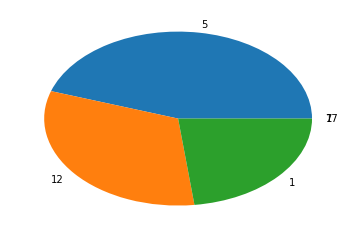

In [16]:
# Inspect a record data
import numpy as np
def inspect_record(doc_lw_id):
    '''
    doc_lw_id is the localwise 'id' column
    '''
    record = df_jobs[df_jobs.id == doc_lw_id]
    doc_index = record.index.values[0]
    print 'doc index/record id: %s/%s\n' % (doc_index, doc_lw_id)
    
    d = record.to_dict()
    print 'record data:'
    print "{:<15} {:<15}".format('Key','Value')
    for key in sorted(d.keys()):
        print "{:<15} {:<15}".format(key, d[key])

    print
    print 'vector values'
    feature_names = tm.vectorizer.get_feature_names()
    feature_index = tm.document_term_mat[doc_index,:].nonzero()[1]

    tfidf_scores = zip(feature_index, [tm.document_term_mat[doc_index, x] for x in feature_index])
    tfidf_dict = {s: feature_names[i] for (i, s) in tfidf_scores}
    #print
    for i, key in enumerate(sorted(tfidf_dict.keys(), reverse=True)):
        if i < 10:
            print "{:<15} {:<15}".format(tfidf_dict[key], key)
    
    probs = tm.get_normalized_probs(tm.W[doc_index])
    ordered_idxs = np.argsort(probs)[::-1]
    top_topic = ordered_idxs[0]
    # print "Topic probabilities:\n%s\n" % probs
    print "Top Tags:\n%s\n" % get_topic_top_tags(top_topic, 3)
    print "Top Topics:\n"
    print 'top topic: %s' % record.top_topic.values[0]
    print 'top topic weight: %s' % record.top_topic_weight.values[0]
    for i in range(5):
        print (ordered_idxs[i], probs[ordered_idxs[i]])

    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    plt.pie(probs[ordered_idxs[:5]], labels=ordered_idxs[:5])
    #print df_jobs.iloc[row_num].description
inspect_record(doc_idx)
#inspect_record(doc_lw_id)

# "Similar Job Posting" recommendation

In [17]:
# # Subset the jobs by topic as a preprocessing step
# job_subset = df_jobs[(df_jobs.top_topic == int(12))]
# job_subset.iloc[doc_idx]

In [18]:
tm.vectorizer.ngram_range

(1, 1)

In [24]:
import re

# # Vectorizer to be used throughout
# vectorizer = TfidfVectorizer(token_pattern=topic_model.get_token_pattern(),
#                                               min_df=min_df,
#                                               max_df=max_df,                             
#                                               max_features=max_vocab_size,
#                                               stop_words=topic_model.get_stop_words(),
#                                               ngram_range=ngram_range)
# Helper utility
# d2v_ut = d2v_utils.D2V_Utils(tm.vectorizer)

# def get_doc2vec_model(docs):
# ...
#     return _d2v_model

# Given a record, recommend another record
# Flexible logic here...
def make_recommendation(job_lw_id):
    # Get the input job's topic
    query_job = df_jobs[df_jobs.id == job_lw_id]
    source_prob = query_job.top_topic_weight.values[0]
    source_title = query_job.title.values[0]
    topic = query_job.top_topic.values[0]
    print 'Query job topic: %s' % topic
    print 'Query job:'
    print '- job id: %s (topic prob: %s)' % (job_lw_id, source_prob)
    print '- topic top tags: \n%s\n' % get_topic_top_tags(int(topic), 3)
    print '- title: %s' % query_job.title.values[0]
    print '- desc: %s\n' % query_job.description.values[0][:300]
    
    # Get the input job's tags
    tags = query_job.tag_names
    print 'tags: %s' % tags.values[0].split(',')
    
    #
    # Filter..
    #
    # 1. Subset jobs with same title
    #
    # 2. subset jobs with same topic
    job_subset = df_jobs[(df_jobs.top_topic == int(topic))]
    # Get all records with that topic with high weight
    #topic_records = df_jobs[(df_jobs.top_topic == int(topic)) & (df_jobs.top_topic_weight > .85)]
    # Get all records with that topic and title
    #topic_records = df_jobs[(df_jobs.top_topic == int(topic)) & (df_jobs.title == source_title)]
    
    print 'Num records after filter:',job_subset.shape
    
    # 
    # Select record
    # 
    # 1. Doc2Vec on subset of jobs
    # d2v_model = nlp_utils.get_doc2vec_model(job_subset.description)
    d2v_model = nlp_utils.get_doc2vec_model(job_subset.description)
    
    from nltk.stem import WordNetLemmatizer
    analyzer = tm.vectorizer.build_analyzer()
    sw = nlp_utils.get_stop_words()
    pattern = re.compile(nlp_utils.get_token_pattern())
    lemmer = WordNetLemmatizer()
    
    # If have the query tag id, probably not...
    #id_str = 'job_posting_' + str(job_id)
    #sims = d2v_model.docvecs.most_similar(id_str)
    # otherwise, clear text query by infer vector
    doc = query_job.description.values[0]
    # print doc
    tokens = [lemmer.lemmatize(w) for w in list(set(analyzer(doc)) - set(sw))
                 if pattern.match(w)]
    new_vector = d2v_model.infer_vector(tokens)
    sims = d2v_model.docvecs.most_similar([new_vector]) #gives you top 10 document tags and their cosine similarity
    sims
    print sims
    top_job = sims[0][0]
    r_index = int(top_job.split('_')[:1:-1][0])
    
    # 2. Pick one at random
    # r = np.random.randint(low=0, high=job_subset.shape[0]-1)
    
    df_j_rec = job_subset.iloc[r_index].id
    return df_j_rec

recommended_doc_lw_id = make_recommendation(doc_lw_id)
recommended_doc_top_prob = df_jobs[df_jobs.id == recommended_doc_lw_id].top_topic_weight.values[0]
print 'Recommending job %s (prob %s)' % (recommended_doc_lw_id, recommended_doc_top_prob)
print '- idx: %s' % df_jobs[df_jobs.id == recommended_doc_lw_id].index.values[0]
print '- id: %s' % recommended_doc_lw_id
print '- title: %s' % df_jobs[df_jobs.id == recommended_doc_lw_id].title.values[0]
print '- desc: %s' % df_jobs[df_jobs.id == recommended_doc_lw_id].description.values[0][:100]

Query job topic: 10
Query job:
- job id: 6936 (topic prob: 0.9947657640130495)
- topic top tags: 
                           tag name count  tag name proportion
Food & Drink                          350             0.870647
Retail,Food & Drink                    30             0.074627
Family Owned,Food & Drink              22             0.054726

- title: Barista
- desc: **Hiring for barista position**

Minimum one year restaurant or barista experience required.&nbsp;Will train to fit our flavor.

Must be available to work at least three days, up to five days per week &nbsp;

**Weekday and weekend availability required**&nbsp;

Shifts are from 7:30am-3:30pm - must b

tags: ['Food & Drink']
Num records after filter: (644, 7)
Tokenizing docs...
- Time: 0.630s.

Building Doc2Vec vocabulary...
- Time: 0.086s.

Doc2Vec model train...
- Time: 2.642s.

[('job_posting_634', 0.9111703038215637), ('job_posting_358', 0.9041643142700195), ('job_posting_4', 0.900353729724884), ('job_posting_131',

In [57]:
# df_jobs[df_jobs.title.str.contains('busser')]

In [59]:
term_ranks = tm.rank_terms()

top_n = 20
print "Top %s terms across all %s terms (ranked by the term's vector tfidf sum):" % (top_n, len(tm.vectorizer.vocabulary_))
for i, pair in enumerate( term_ranks[0:top_n] ):
    print( "  %02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

Top 20 terms across all 10000 terms (ranked by the term's vector tfidf sum):
  01. manager (1827.14)
  02. cook (1814.95)
  03. assistant (1680.55)
  04. sale (1420.52)
  05. service (1203.72)
  06. line (1121.56)
  07. teacher (1095.21)
  08. server (1061.95)
  09. associate (1013.36)
  10. program (991.68)
  11. customer (964.82)
  12. coordinator (716.12)
  13. food (681.47)
  14. office (680.32)
  15. school (674.48)
  16. dishwasher (623.05)
  17. restaurant (618.90)
  18. marketing (586.60)
  19. kitchen (572.28)
  20. member (559.65)


# Determine optimal number of clusters

Applying NMF for k=3 ...
- Time: 4.138s.
Applying NMF for k=4 ...
- Time: 3.806s.
Applying NMF for k=5 ...
- Time: 7.519s.
Applying NMF for k=6 ...
- Time: 4.140s.
Applying NMF for k=7 ...
- Time: 4.963s.
Applying NMF for k=8 ...
- Time: 6.749s.
Applying NMF for k=9 ...
- Time: 6.770s.
Applying NMF for k=10 ...
- Time: 11.183s.
Applying NMF for k=11 ...
- Time: 11.350s.
Applying NMF for k=12 ...
- Time: 13.941s.
Applying NMF for k=13 ...
- Time: 16.115s.
Applying NMF for k=14 ...
- Time: 17.886s.
Applying NMF for k=15 ...
- Time: 18.383s.
Applying NMF for k=16 ...
- Time: 19.725s.
Applying NMF for k=17 ...
- Time: 20.591s.
Applying NMF for k=18 ...
- Time: 14.098s.
Applying NMF for k=19 ...
- Time: 22.921s.
Applying NMF for k=20 ...
- Time: 12.799s.
Applying NMF for k=21 ...
- Time: 25.340s.
Applying NMF for k=22 ...
- Time: 27.186s.
Applying NMF for k=23 ...
- Time: 27.972s.
Applying NMF for k=24 ...
- Time: 15.336s.
Applying NMF for k=25 ...
- Time: 24.899s.
Tokenizing the documents.

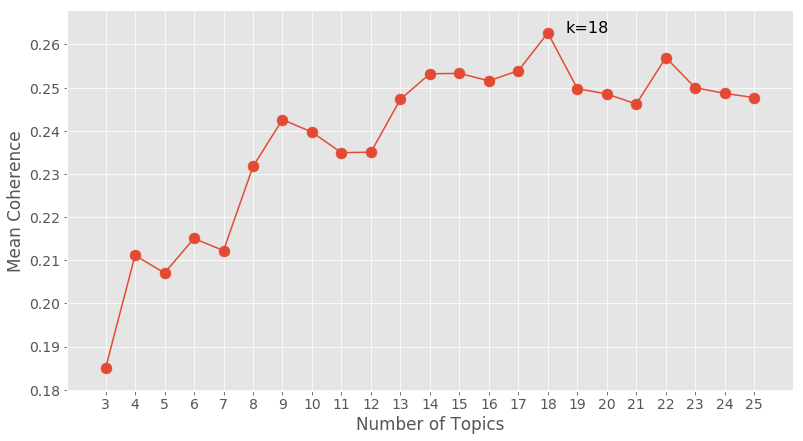

Topic 01: project, marketing, medium, development, design, strategy, organization, event, manage, develop, role, social, campaign, partner, business
Topic 02: standard, lift, safety, procedure, equipment, clean, ensure, guest, item, cleaning, stand, responsibility, period, product, lb
Topic 03: student, school, teaching, class, teach, teacher, tutor, academic, instructor, college, grade, curriculum, learning, lesson, classroom
Topic 04: persuasion, selects, extent, strictly, admitted, treated, discrimination, religious, relating, staffing, character, political, discus, fair, protected
Topic 05: program, family, community, agency, service, life, client, intervention, adult, support, child, participant, assessment, county, provides
Topic 06: restaurant, food, wine, dining, guest, bar, fast, fine, beer, year, paced, chef, menu, cocktail, hospitality
Topic 07: test, drug, pas, clearance, tutor, check, negative, fingerprint, exam, background, testing, criminal, scan, fingerprinting, standar

In [15]:
# Calculate the optimal k using word2vec for coherence metric
topic_model.plot_optimal_k(docs.tolist(), tm.document_term_mat, tm.vectorizer,
                           kmin=3, kmax=25, dim_size=500, min_df=min_df, 
                           max_vocab_size=max_vocab_size, num_top_terms=15,
                           model_file_path='./data/',
                           model_file_name='w2v-model.bin')

In [20]:
# import pdb; pdb.set_trace()
len(tm.vectorizer.get_feature_names())

5000

In [ ]:
import numpy as np
#doc_contents = df_jobs.description[20000:20001]
doc_contents = df_jobs.description.iloc[21]

#document_term_mat = tm.vectorizer.transform(['• The House approved the most sweeping tax rewrite in decades mostly along party lines, with lawmakers voting 227-203.• The action has now moved to the Senate, which is expected to vote on the bill, possibly on Tuesday evening.'])
document_term_mat = tm.vectorizer.transform([doc_contents])
W = tm.model.transform(document_term_mat)
H = tm.model.components_

print W.shape
print H.shape
print 'W:', W
probs = W / W.sum(axis=1, keepdims=True)
print 'W probs:', probs
print
print 'H:', H

print np.argsort(W)[0][::-1]

#print doc_contents.iloc[0]
print doc_contents